In [1]:

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!pip install transformers

     |████████████████████████████████| 2.2MB 9.0MB/s 
     |████████████████████████████████| 870kB 46.7MB/s 
     |████████████████████████████████| 3.3MB 54.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=c2a08d081379a694bff17067e999236cda0c4a6c74c4e0fb57f6d5be3693189c
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


step1:Import required library

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense,Input
from keras.models import Model
import torch
import transformers

Load the dataset

In [6]:
df = pd.read_json("/content/drive/MyDrive/Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


Drop article link from the dataset

In [7]:
df.drop('article_link', axis=1, inplace=True)

In [8]:
df.head(4)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1


In [9]:
import nltk
nltk.download('stopwords')

#from stop_words import get_stop_words
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


step2:Data preprocessing

In [10]:
import string
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
print(stop)

{"you'd", '-', '#', 'ain', 'only', 'are', 'yours', 'up', 'out', 'on', 'itself', '*', 'once', 'weren', 'do', 'just', "didn't", 'herself', "she's", '?', '$', 'more', "shouldn't", 'further', 'it', 'our', ']', 'between', 'how', '+', '}', 'had', 'theirs', 'very', 'over', 'ours', 'with', 'themselves', 'through', '{', "mightn't", 'under', 'hers', "you'll", 'its', 'having', 'yourself', 'mightn', '\\', 'until', "that'll", 'ourselves', "you've", 'his', 'above', ')', '|', '_', 'the', 'doesn', "shan't", '[', 've', 'into', 'same', 't', '!', 'such', 'can', 'is', "aren't", 'doing', 'we', 'so', 'have', '^', 'against', 'as', 'few', 'will', ',', '(', ':', 'if', 'their', '.', 'there', 'hasn', 'my', 'by', 'ma', 'yourselves', '%', 'you', 'has', 'both', '/', 'haven', 'too', 'some', 'who', 'or', 'isn', 'couldn', 'but', 'which', 'and', 'own', '=', ';', 'not', 'was', 'about', "hadn't", 'him', "haven't", 'all', 'where', '&', 'myself', 'again', 'does', 'for', 'any', 'were', 'what', 'don', 'down', 'hadn', 'during

In [11]:
!pip install beautifulsoup4

In [12]:
 from bs4 import BeautifulSoup

In [13]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)


In [14]:
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

Removing the noisy text from the 'headline column'

In [15]:
#Apply function on 'headline' column
import re

df['headline']=df['headline'].apply(denoise_text)

In [16]:
df['headline']

0        former versace store clerk sues secret minorit...
1            revival catches thorny political better worse
2        mom starting fear web series closest thing gra...
3                boehner wants wife come alternative ideas
4          rowling wishes snape happy birthday magical way
                               ...                        
26704                              american politics moral
26705                                           best hikes
26706                                    reparations obama
26707    israeli ban targeting boycott supporters raise...
26708                                 gourmet gifts foodie
Name: headline, Length: 26709, dtype: object

step3:Creating the vocabulary

In [17]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.headline)
print(type(corpus))
print(len(corpus))
corpus[:20]

<class 'list'>
163287


['former',
 'versace',
 'store',
 'clerk',
 'sues',
 'secret',
 'minority',
 'shoppers',
 'revival',
 'catches',
 'thorny',
 'political',
 'better',
 'worse',
 'mom',
 'starting',
 'fear',
 'web',
 'series',
 'closest']

In [18]:
#To count the word counts
from collections import Counter
counter = Counter(corpus)
print(type(counter),len(counter))
most_common = counter.most_common(20)
most_common = dict(most_common)
print(most_common)

<class 'collections.Counter'> 22782
{'new': 1485, 'man': 1229, 'trump': 1157, 'one': 487, 'area': 484, 'donald': 468, 'says': 450, 'woman': 420, 'day': 391, 'first': 389, 'get': 385, 'like': 382, 'time': 369, 'people': 341, 'still': 326, 'obama': 325, 'make': 320, 'house': 319, 'life': 314, 'women': 310}


Step4:Model Building

In [19]:
#using DistilBERT which is a small, fast, cheap and light Transformer model 

from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
# Save the loaded tokenizer locally,saving on google drive
tokenizer.save_pretrained('/content/drive/MyDrive/distilbert_tokenizer')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('/content/drive/MyDrive/distilbert_tokenizer/vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

Tokenization steps:
1.Firstly, tokenize all words in the sentence corpus
2.Next, all the tokens are embedded using the learned embeddings from a WordPiece Tokenizer. For each word we get 786 dim. vector representation.
3.Segment Embedding - Helps in distinguishing the words belonging to different sentences.
4.Positional Embedding - This is used to provide the positional understanding for each word.

In [21]:
X = df['headline']
y = df['is_sarcastic']
print(X.shape)
print(y.shape)

(26709,)
(26709,)


In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0 , stratify = y)
print(X_train[:2])
print(type(X_train))
print(X_train.shape)

3508             clinton commissions john williams compose
23723    expectant parents throw values together last m...
Name: headline, dtype: object
<class 'pandas.core.series.Series'>
(20031,)


In [35]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512, enable_padding=True):

    tokenizer.enable_truncation(max_length=maxlen)
    if enable_padding:
        tokenizer.enable_padding(length=maxlen)#max_length=maxlen
    #tokenizer.enable_padding(max_length=None)
    all_ids = []
    #print(texts)
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()#texts[i:i+chunk_size].tolist()
        
        #print(text_chunk)
        encs = tokenizer.encode_batch(text_chunk)
        #print(encs)
        all_ids.extend([enc.ids for enc in encs])#np.array(enc.ids) for enc in encs[enc.ids for enc in encs]
        #arr=np.vstack([enc.ids for enc in encs])
        #arr=np.hstack([enc.ids for enc in encs])
    #all_ids=np.asarray(all_ids)    
    #print(type(all_ids))
    #print(arr)
    return np.array(all_ids)#np.array(all_ids)
    #return arr

In [36]:
#import tensorflow as tf

#X_train=np.asarray(X_train).astype(np.float32)
#X_test=np.asarray(X_test).astype(np.float32)
x_train = fast_encode(X_train, fast_tokenizer, maxlen=400)
x_test = fast_encode(X_test, fast_tokenizer, maxlen=400)

#x_train=np.expand_dims(x_train, axis=1)
#x_train = tf.convert_to_tensor(x_train, dtype=tf.int64) 
#x_train=np.asarray(x_train)
#x_train = np.asarray(x_train).astype(np.float32)
#print(type(x_train),x_train.shape)
#print(x_train.shape[0])#20031
#xtrain_lst=[]
#for i in range(x_train.shape[0]):
   
   #x_train[i]=np.array(x_train[i])
   #print(x_train[i],type(x_train[i]))
   #xtrain_lst.append(np.hstack(x_train[i]))
print(x_train[:3],x_train.shape)
#print(x_test[:5],x_test.shape)
#x_train=np.array(xtrain_lst)
#print(x_train)

[[  101  7207 13239 ...     0     0     0]
 [  101  5987  4630 ...     0     0     0]
 [  101  3113 15302 ...     0     0     0]] (20031, 400)


using the pre-trained BERT model(used parallelly for masked language and next sentence prediction model) . Now after getting the pre-trained model, we can fine-tune the model for our own specific task.

The key thing to notice is here is that for our final prediction we would only be using the output generated by the first token ([CLS]), after which we use a sigmoid activation for final prediction.

In [37]:
def build_model(transformer, max_len=None):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
   
    sequence_output = transformer(input_word_ids)[0]
    
    cls_token = sequence_output[:, 0, :]
    
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [38]:
#This model is used in tensorflow mode
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')#either  base-uncased or base-cased can be used 

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [39]:
model = build_model(bert_model, max_len=400)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 400)]             0         
_________________________________________________________________
tf_distil_bert_model_1 (TFDi TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem_3 ( (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 769       
Total params: 66,363,649
Trainable params: 66,363,649
Non-trainable params: 0
_________________________________________________________________


step5:Model Training,Prediction and EDA

In [40]:
history = model.fit(x_train,y_train,batch_size = 10 ,validation_data=(x_test,y_test),epochs = 1)

2004/2004 [==============================] - 602s 297ms/step - loss: 0.6190 - accuracy: 0.6370 - val_loss: 0.4070 - val_accuracy: 0.8109


In [51]:
pred = model.predict(x_test)
pred = np.round(pred).astype(int)#1 indiactes sarcasm presence, 0 indicates non-sarcasm
text=fast_tokenizer.decode(x_test[1])
print(text)
print(x_test[:5])
print(pred[:5])

watch cat lose mind faced optical illusion
[[ 101 2198 7380 ...    0    0    0]
 [ 101 3422 4937 ...    0    0    0]
 [ 101 3611 3201 ...    0    0    0]
 [ 101 8495 2708 ...    0    0    0]
 [ 101 9577 2158 ...    0    0    0]]
[[0]
 [0]
 [1]
 [1]
 [1]]


In [69]:
#predict text and sarcasm using DistillBert Model
pred_dict={}
for i in range(10,20):
    pred_dict['headline']=(fast_tokenizer.decode(x_test[i]))
    pred_dict['is_sarcastic']=pred[i]#(np.round(pred[i]).astype(int))
    print(pred_dict)


{'headline': 'cease print edition', 'is_sarcastic': array([0])}
{'headline': 'selma teaches us mixing pills alcohol', 'is_sarcastic': array([0])}
{'headline': 'job market still years away full recovery', 'is_sarcastic': array([1])}
{'headline': 'shopper takes bizarre journey beyond bath', 'is_sarcastic': array([1])}
{'headline': 'cnbc cameraman believe filming another blog computer monitor', 'is_sarcastic': array([0])}
{'headline': 'germans', 'is_sarcastic': array([0])}
{'headline': 'syrian electronic army little fun inevitable upcoming deaths hands rebels', 'is_sarcastic': array([1])}
{'headline': 'boardroom begins quake ceo announces vision future company', 'is_sarcastic': array([1])}
{'headline': 'candidate greg gianforte gets slammed scorching new memes', 'is_sarcastic': array([1])}
{'headline': 'cabinet move new open plan offices', 'is_sarcastic': array([1])}


In [44]:
cm = confusion_matrix(y_test,pred)
print('confusion matrix',cm)

confusion matrix [[3413  334]
 [ 929 2002]]


Text(24.0, 0.5, 'Actual')

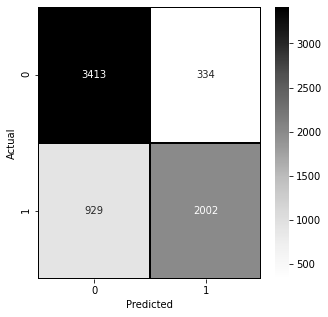

In [49]:
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Greys", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")